# BLOCK 3 : LSTM
___

## 1. Requirements

In [236]:
# !pip3 install -r requirements.txt

## 2. Libraries

In [237]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go



## 3. Open PARQUET File

In [238]:
# Load file .parquet to Pandas DF
df = pd.read_parquet(r"C:\WORKSPACES\DATA\TRANSFORMED\iNat_df_time.parquet")

In [239]:
# df = df.rename(columns = {"year_month": "date", "observation_id": "total"})

## 4. Analysis

### 4.1. WORLD - Total Observation IDs by Month and Year

In [262]:
# Parameters for the histogram
fig_bar = px.bar(
    df,
    x = "date",
    y = "total",
    labels = {
        "date": "Timeline",
        "total": "Total Number of Observation IDs"
        },
    title = "WORLD - Total Observation IDs by Month and Year"
    )
fig_bar.update_xaxes(type = "category", tickangle = 270)
fig_bar.update_layout(autosize = False, width = 900, height = 600)

fig_bar.show()

In [241]:
# Add a line trace for the maximum values
fig_bar.add_trace(
    go.Scatter(
        x = df["date"],
        y = df["total"],
        mode = "lines",
        name = "Total Observation IDs",
        line = dict(color = "red"),
    )
)

In [263]:
# Create a line plot for the maximum values
fig_line = go.Figure(
    go.Scatter(
        x = df["date"],
        y = df["total"],
        mode = "lines",
        name = "Total Observation IDs",
        line=dict(color="red"),
    )
)

fig_line.update_layout(
    title = "WORLD - Total Observation IDs by Month and Year",
    xaxis_title = "Timeline",
    yaxis_title = "Total Number of Observation IDs",
    autosize = False, 
    width = 900, 
    height = 600
)

fig_line.show()

### 4.2. LSTM

In [ ]:
# x last month
test_len = 18

ind = len(df) - test_len
train = df[:ind] #train : all data except last x months
test = df[ind:]

print(f"Dataset train Length : {len(train)}")
print(f"Dataset test Length : {len(test)}")


Dataset train Length : 110
Dataset test Length : 18


In [244]:
# Reshape data
train_reshape = train["total"].values.reshape(-1, 1)
test_reshape = test["total"].values.reshape(-1, 1)

# Apply the scaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train_reshape)
test_sc = sc.transform(test_reshape)


### 4.3. Setup Data generators

In [245]:
# x data (sequence_length) to predict the next one (out_len)
sequence_length = 12 
batch_size = 1

# Train Generator
train_gen = TimeseriesGenerator(data = train_sc,
                                targets = train_sc,
                                length = sequence_length,
                                batch_size = batch_size)

# Test Generator
test_gen = TimeseriesGenerator(data = test_sc,
                               targets = test_sc,
                               length = sequence_length,
                               batch_size = batch_size)

### 4.4. LSTM Parameters

In [246]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(150, activation=  "relu", input_shape = (sequence_length, 1)))

# Params
model.add(Dropout(0.40)) 
model.add(Dense(1))
model.compile(
    optimizer = "Adam",
    loss = "mse"
    )

model.fit(train_gen, validation_data = test_gen, epochs = 100)

model.reset_states()


Epoch 1/100


98/98 [==============================] - 1s 4ms/step - loss: 0.0310 - val_loss: 0.1566
Epoch 2/100
98/98 [==============================] - 0s 3ms/step - loss: 0.0262 - val_loss: 0.0659
Epoch 3/100
98/98 [==============================] - 0s 3ms/step - loss: 0.0233 - val_loss: 0.0852
Epoch 4/100
98/98 [==============================] - 0s 3ms/step - loss: 0.0219 - val_loss: 0.1496
Epoch 5/100
98/98 [==============================] - 0s 3ms/step - loss: 0.0136 - val_loss: 0.0366
Epoch 6/100
98/98 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0219
Epoch 7/100
98/98 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.0205
Epoch 8/100
98/98 [==============================] - 0s 3ms/step - loss: 0.0172 - val_loss: 0.1191
Epoch 9/100
98/98 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0169
Epoch 10/100
98/98 [==============================] - 0s 3ms/step - loss: 0.0123 - val_loss: 0.1910
Epoch 11/100
98/98 [=

In [247]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 150)               91200     
                                                                 
 dropout_9 (Dropout)         (None, 150)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91351 (356.84 KB)
Trainable params: 91351 (356.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [248]:
# Define empty list
y_pred = [] 

# x Last train data t predict next :
train_sc_lastrows = train_sc[-sequence_length:] 

# Reshape (1, 12, 1)
batch = train_sc_lastrows.reshape((1, sequence_length, 1)) 

for _ in range(len(test)): 
  pred = model.predict(batch) # Prediction
  y_pred.append(pred[0]) # Add prediction to y_pred list
  batch = np.append(batch[:,1:,:], [pred], axis = 1) # Remove first "batch" element, add prediction at the end, and make new prediction.

1/1 [==============================] - 0s 14ms/step


In [259]:
# Inverse scaling
y_pred = sc.inverse_transform(y_pred) 

# Add predictions to original dataset test to compare:
test.loc[:, "prediction"] = y_pred
# test["prediction"] = y_pred 

In [250]:
test

,date,total,prediction
110,2022-03,909891,1.259110e+06
111,2022-04,1620577,1.763578e+06
112,2022-05,1996397,1.981561e+06
113,2022-06,1853805,1.922681e+06
114,2022-07,1997773,1.831078e+06
115,2022-08,1615159,1.618034e+06
116,2022-09,1363086,1.379395e+06
117,2022-10,1248351,1.105170e+06
118,2022-11,780611,8.111897e+05
119,2022-12,669797,6.589502e+05


<Axes: >

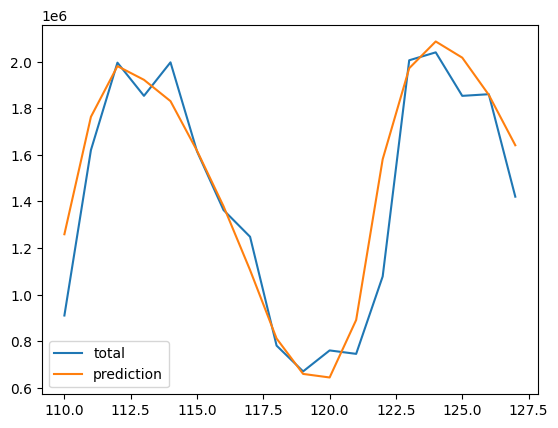

In [251]:
test.plot()

In [252]:
rmse = mean_squared_error(test["total"], test["prediction"])**0.5
df_mean = df["total"].mean()
print(f"RMSE : {rmse}")
print(f"Scatter Index: {rmse / df_mean}")

r2 = r2_score(test["total"], test["prediction"])
print(f"R-squared : {r2}")

RMSE : 177078.40444934514
Scatter Index: 0.33066526357866577
R-squared : 0.869147005454696


## 5. Using the model to predict the next X months

In [253]:
# Dataset scaling
df_reshape = df["total"].values.reshape(-1, 1)
df_sc = sc.fit_transform(df_reshape)

In [254]:
interval = 36
sequence_length = 12
forecast = []
sc_df_lastrows = df_sc[-sequence_length:]
batch = sc_df_lastrows.reshape((1, sequence_length, 1))

for _ in range(interval):
  pred = model.predict(batch)
  forecast.append(pred[0]) 
  batch = np.append(batch[:, 1:, :], [pred], axis = 1)

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


In [255]:
# Inverse scaling
forecast = sc.inverse_transform(forecast)

In [256]:
# Create a new dataframe with future dates
fc_index = pd.date_range(start = "2023-09", periods = interval, freq = "MS")
fc_df = pd.DataFrame(forecast, index = fc_index, columns = ["forecast"])

In [257]:
# Plot forecast
fig_fcst = px.line(df, x = "date", y = "total", title = "Time Series Data with Forecast")
fig_fcst.add_scatter(
    x = fc_df.index,
    y = fc_df["forecast"],
    mode = "lines",
    name = "Forecast"
    )

fig_fcst.update_layout(
    title = "WORLD - Total Observation IDs by Year with Forecast",
    xaxis_title = "Timeline",
    yaxis_title = "Total Number of Observation IDs",
    autosize = False, 
    width = 900, 
    height = 600
)

fig_fcst.show()